#1. Set up environment

In [ ]:
# Connecting Google Colab to Google Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/corino/train

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1VNycZC_xFFpxCAqmRhHpLYkv_K4xtGLO/corino/train


In [ ]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
from sklearn import preprocessing
import pandas as pd
import scipy.signal
import pickle
import csv

In [ ]:
!ls

S001_128_ann.mat  S022_128_ann.mat  S043_128_ann.mat  S080_250_ann.mat	S101_250_ann.mat
S001_128.mat	  S022_128.mat	    S043_128.mat      S080_250.mat	S101_250.mat
S001_128_spk.mat  S022_128_spk.mat  S043_128_spk.mat  S080_250_spk.mat	S101_250_spk.mat
S002_128_ann.mat  S023_128_ann.mat  S044_128_ann.mat  S081_250_ann.mat	S102_250_ann.mat
S002_128.mat	  S023_128.mat	    S044_128.mat      S081_250.mat	S102_250.mat
S002_128_spk.mat  S023_128_spk.mat  S044_128_spk.mat  S081_250_spk.mat	S102_250_spk.mat
S003_128_ann.mat  S024_128_ann.mat  S045_128_ann.mat  S082_250_ann.mat	S103_250_ann.mat
S003_128.mat	  S024_128.mat	    S045_128.mat      S082_250.mat	S103_250.mat
S003_128_spk.mat  S024_128_spk.mat  S045_128_spk.mat  S082_250_spk.mat	S103_250_spk.mat
S004_128_ann.mat  S025_128_ann.mat  S046_128_ann.mat  S083_250_ann.mat	S104_250_ann.mat
S004_128.mat	  S025_128.mat	    S046_128.mat      S083_250.mat	S104_250.mat
S004_128_spk.mat  S025_128_spk.mat  S046_128_spk.mat  S083_250_spk.mat	S104_250_

#1.1 Data importation

We import the files containing the position of the peaks in the signal, which are the files ending with spk.mat.

In [ ]:
# Folder where the files are located
cartella = '/gdrive/My Drive/corino/train'

files = [file for file in os.listdir(cartella) if file.endswith('spk.mat')]

peaks = []

# Loop through all the spk.mat files and load each file into a matrix.
for file in files:
    # Extract the file name without the extension
    nome_file = os.path.splitext(file)[0]

    # create the full path of the file.
    percorso_file = os.path.abspath(os.path.join(cartella, file))

    # load the file
    matrice = scipy.io.loadmat(percorso_file)

    # Add the matrix to the list with the file name as the key.
    peaks.append({nome_file: matrice})

#Now matrices contains a list of dictionaries, each of which has the file name as the key and the matrix as the value.


The same procedure has been done for the other files as well.

We import the files containing the label of the peaks , which are the files ending with ann.mat.

In [ ]:
cartella = '/gdrive/My Drive/corino/train'

files = [file for file in os.listdir(cartella) if file.endswith('ann.mat')]

labels = []

for file in files:
    nome_file = os.path.splitext(file)[0]
    percorso_file = os.path.abspath(os.path.join(cartella, file))
    matrice = scipy.io.loadmat(percorso_file)
    labels.append({nome_file: matrice})

We import the files containing the PPG signals in samples, which are the files ending with 128.mat and 250.mat.

In [ ]:
cartella = '/gdrive/My Drive/corino/train'

files = [file for file in os.listdir(cartella) if file.endswith(('128.mat', '250.mat'))]

signal = []
for file in files:
    nome_file = os.path.splitext(file)[0]
    percorso_file = os.path.abspath(os.path.join(cartella, file))
    matrice = scipy.io.loadmat(percorso_file)
    signal.append({nome_file: matrice})

# 2. Data manipulation and outlier detection

## 2.1 Maintain index correspondences between different lists.


This code cell was created to ensure correspondence between the arrangement of files in different lists so that the i-th file in "peaks" contains the position of peaks of the signal present in the i-th file of "signal," and the same goes for "labels."

To do this, we used the first 8 characters of the file names because they refer to the patient and therefore allow us to associate the peak positions and labels with their respective signals.

In [ ]:
# To have the same order among various files
# extract the first 8 characters from the dictionary key's name.
def estrai_codice(dizionario):
    return list(dizionario.keys())[0][:8]

# Sort the lists based on the first 8 characters of the code.
peaks_nuovo= sorted(peaks, key=estrai_codice)
labels_nuovo = sorted(labels, key=estrai_codice)
signal_nuovo=sorted(signal, key=estrai_codice)

Let's extract from the "labels" list only the part that corresponds to the labels themselves, excluding other information like the patient it refers to.

In [ ]:
label= [elemento[chiave]['labels'] for elemento in labels_nuovo for chiave in elemento]

##2.2 Detection of only physiological peak signals

We see if there are patients with only normal beats. In case there are, our decision is to remove them as we can consider them outliers since our classification task focuses on distinguishing N, V, S peaks. So we can say taht these patients contain uninformative information for our classification and only increase data imbalance.

We save all the patient with only normal peaks

In [ ]:
normal=[]

for i in range(len(label)):
    if all(elemento == 'N' for elemento in label[i]):
        normal.append(i)

In [ ]:
normal

[68, 75, 78, 79, 87, 88, 90, 91, 93, 94, 98, 102, 103, 104]

The total number of patient with only N peaks are 14

## 2.3 Remove outlier and re-sort lists


Let's remove patients with only normal peaks from the three lists: signal_new, labels_new, and peaks_new.

In [ ]:
for index in sorted(normal, reverse=True):
    del labels_nuovo[index]

len(labels_nuovo)

91

In [ ]:
for index in sorted(normal, reverse=True):
    del signal_nuovo[index]

len(signal_nuovo)

91

In [ ]:
for index in sorted(normal, reverse=True):
    del peaks_nuovo[index]

len(peaks_nuovo)

91

So now the number of patients we have, which was 105, becomes 91.

##2.4.Extrapolation of only the meaningful data

In [ ]:
ppg = [elemento[chiave]['ppg'] for elemento in signal_nuovo for chiave in elemento]

In [ ]:
label= [elemento[chiave]['labels'] for elemento in labels_nuovo for chiave in elemento]

In [ ]:
peak = [elemento[chiave]['speaks'] for elemento in peaks_nuovo for chiave in elemento]

In [ ]:
print(len(ppg),len(label),len(peak))

91 91 91


##2.5. Check for Nan value

Nan value in ppg, peaks and labels are checked and no one seems to be present

In [ ]:
nan_ppg=[]

for i in range (len(ppg)):
 for j in range (len(ppg[i])):
  elemento_nullo = np.isnan(ppg[i][j])
  nan_ppg.append(elemento_nullo)


true=any(nan_ppg)
print(true)


False


In [ ]:
nan_peaks=[]

for i in range (len(peak)):
 for j in range (len(peak[i])):
  elemento_nullo = np.isnan(peak[i][j])
  nan_peaks.append(elemento_nullo)

true=any(nan_peaks)
print(true)


False


In [ ]:
count_nan = 0
for i in range (len(label)):
 for j in range (len(label[i])):
  if label[i][j] == 'NaN':
    count_nan += 1

print(count_nan)


0


# 3.Signal Processing

##3.1. Downsampling from 250Hz signals to 128Hz


The first step in the preprocessing is to downsample the signal with higher sampling frequency, i.e 250 Hz so as to unify all the signals to the same sampling frequency (180 Hz). The selection of downsampling with respect to oversampling is led by the fact that, in the case of downsampling, the number of samples is reduced, inevitably lowering the resolution and, consequently, the quality of the signal. In the case of upsampling, the number of samples is increased, but it doesn't necessarily improve resolution or quality; in fact, the added samples are computed and not actual measurements.


We plot the distribution of signal lengths. We can see that the lengths are around 200000, corresponding to samples with fs=128Hz, and around 400000, corresponding to samples with fs=250 Hz.

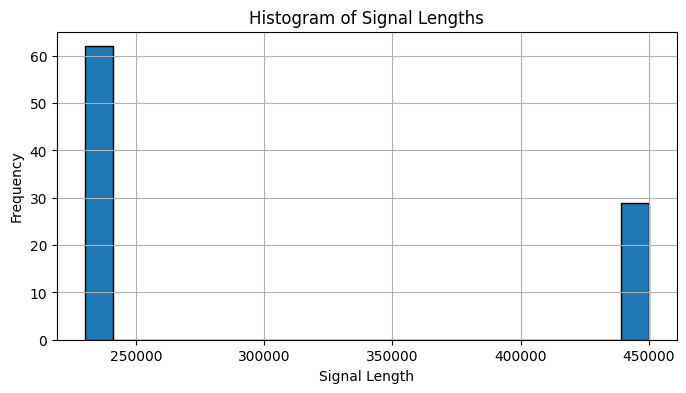

In [ ]:
import matplotlib.pyplot as plt

signal_lengths = [len(signal) for signal in ppg]

# Create a histogram of signal lengths
plt.figure(figsize=(8, 4), dpi=100)
plt.hist(signal_lengths, bins=20, edgecolor='black')
plt.xlabel('Signal Length')
plt.ylabel('Frequency')
plt.title('Histogram of Signal Lengths')
plt.grid(True)
plt.show()


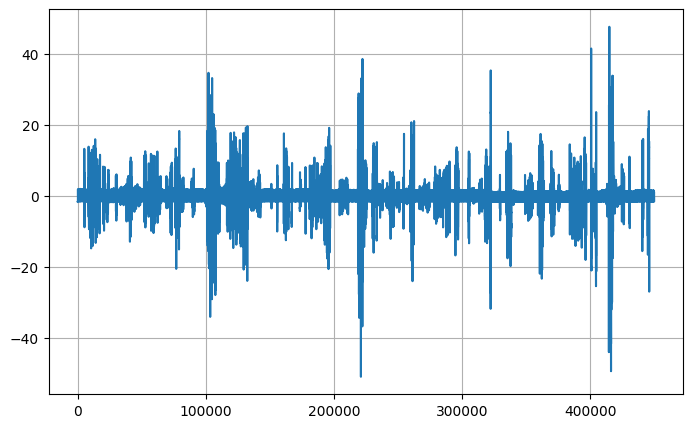

In [ ]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.plot(ppg[90])
plt.grid()


We apply downsampling only to the signals with fs=250 Hz and to the respective positions of the peaks

In [ ]:
from scipy.signal import resample

def downsample(signal_orig, rpeaks, signal_fs, fs_new=128):
    """ Given the signal and its annotation, downsample the signal and
        modify the positions of the annotations
    """
    fs = signal_fs

    new_num_samples = int(len(signal_orig)/fs*fs_new)
    downsamp_signal = np.array(resample(signal_orig, new_num_samples))

    downsamp_ann = rpeaks/(fs/fs_new)
    downsamp_ann = np.round(downsamp_ann).astype(int)

    return downsamp_signal, downsamp_ann


From the initial data, we have seen that patients with fs=128 Hz go up to 62. So, we apply downsampling from 63 to 91.

So the cicle start from 62 to 91 because the first index is 0 not 1





In [ ]:
for i in range(62, 91):
  ppg[i], peak[i] = downsample(ppg[i], peak[i], signal_fs=250, fs_new=128)

Let's plot the distribution of signal lengths after downsampling, and we can observe that now the lengths are all concentrated around 200000.

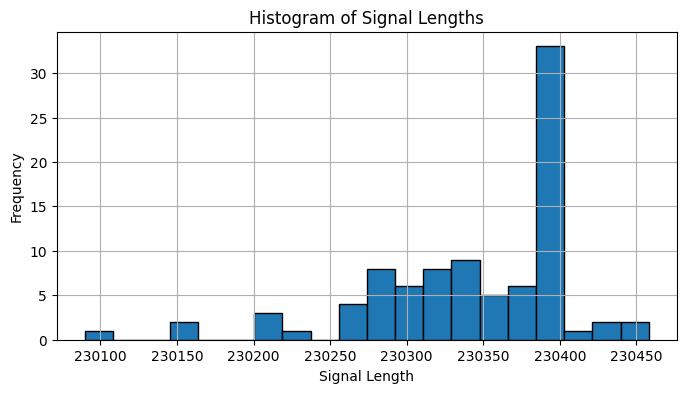

In [ ]:
signal_lengths = [len(signal) for signal in ppg]
# Create a histogram of signal lengths
plt.figure(figsize=(8, 4), dpi=100)
plt.hist(signal_lengths, bins=20, edgecolor='black')
plt.xlabel('Signal Length')
plt.ylabel('Frequency')
plt.title('Histogram of Signal Lengths')
plt.grid(True)
plt.show()


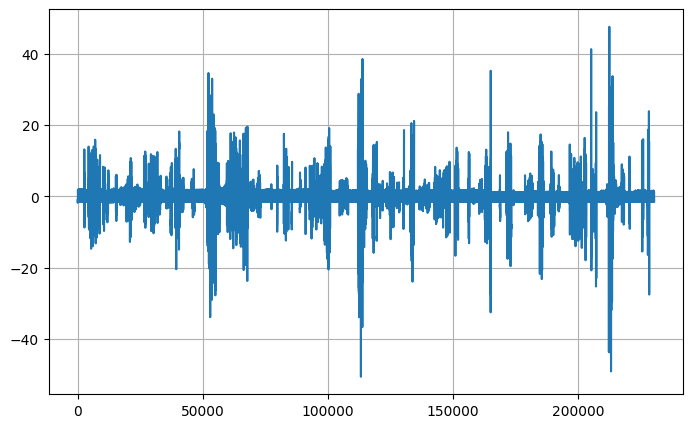

In [ ]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.plot(ppg[90])
plt.grid()

##3.2. Delete movement artifacts

We noticed that there are very noisy parts in the signals due to movement artifacts. These segments of the signal do not carry any useful information that can be utilized for classification. Therefore, we have decided to remove them.

It is observed that the PPG signal typically oscillates within a limited amplitude range, while movement artefacts exhibit a wide variation in amplitude


So we have defined a function to remove artifacts. To remove artifacts, we consider a sliding window of width 90 samples. If there are more than 5 samples within this window with a height < -2.2 or > 2.2, we set all the samples within the window to 0. So the idea is to have zeros instead of artifacts in the signal.

In [ ]:
def rimuovi_artefatti_con_limiti(segnale, soglia_inferiore, soglia_superiore, limite_fuori_soglia):
    lunghezza_finestra = 90

    for i in range(len(segnale) - lunghezza_finestra + 1):
        finestra = segnale[i:i + lunghezza_finestra]  #Through a sliding window, we analyze a portion of the signal at a time.
        conteggio_sopra_soglia = np.sum((finestra > soglia_superiore) | (finestra < soglia_inferiore)) #count the number of samples that overcome the threshold

        if conteggio_sopra_soglia > limite_fuori_soglia:
            segnale[i:i + lunghezza_finestra] = 0   #if more than N samples equal to limite_fuori_soglia are > soglia_superiore or < soglia_inferiore
            # put the signal inside the window equal to 0
    return segnale


In [ ]:
#make the deepcopy in order to plot the ppg raw signal
import copy
ppg1 = copy.deepcopy(ppg)

In [ ]:
#Application of the function to remove the artifact
ppg_cleaned_final = []
for i in range(0,91):
  ppg_cleaned_final.append(rimuovi_artefatti_con_limiti(ppg[i], soglia_inferiore=-2.2, soglia_superiore=2.2, limite_fuori_soglia=5))


Another check was applied to the signal, removing all samples < -2.2 and > 2.5 to ensure the removal of all artifacts.

In [ ]:
def rimuovi_punti_fuori_soglia(segnale, soglia_inferiore=-2.2, soglia_superiore=2.5):
    segnale[(segnale > soglia_superiore) | (segnale < soglia_inferiore)] = 0 #if the sample overcome the threshold put it equal to 0
    return segnale

In [ ]:
#Application of the function
ppg_cleaned_final1 = []
for i in range(0,91):
  ppg_cleaned_final1.append(rimuovi_punti_fuori_soglia(ppg_cleaned_final[i], soglia_inferiore=-2.2, soglia_superiore=2.5))

 plot the raw signal and the signal without artifacts to show the difference.

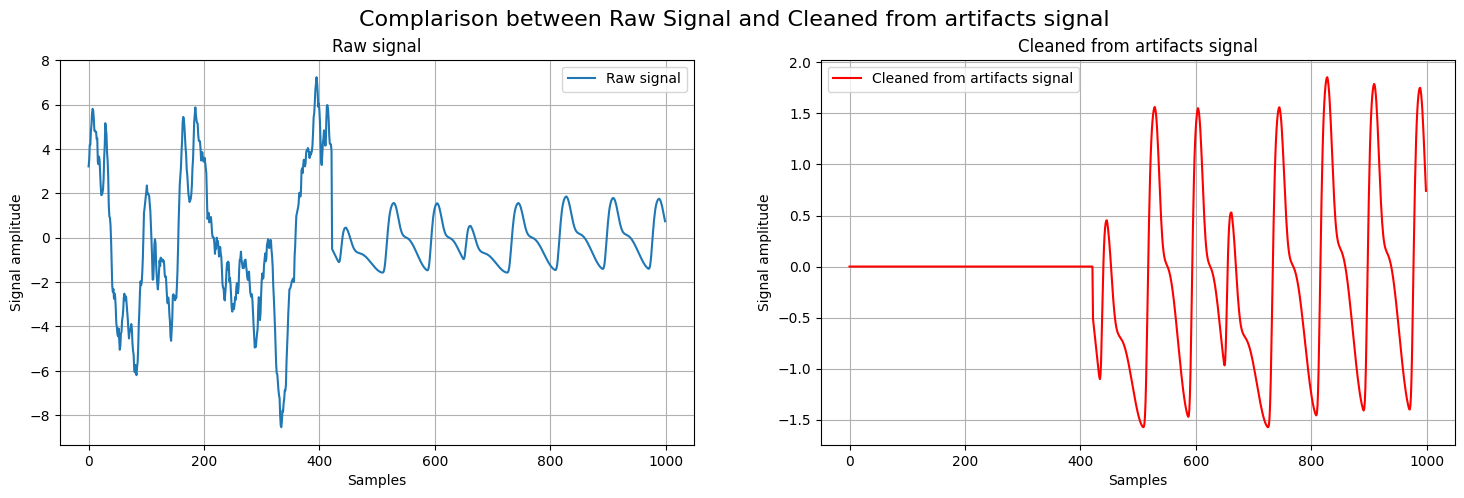

In [ ]:
# Processed signal is the signal without the artifacts
processed_signal = ppg_cleaned_final1[9][3000:4000]
ppg_signal = ppg1[9][3000:4000]

plt.figure(figsize=(18, 5))

# Grafico del segnale originale
plt.subplot(1, 2, 1)
plt.plot(ppg_signal, label='Raw signal')
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Signal amplitude')
plt.title('Raw signal')
plt.legend()

# Grafico del segnale filtrato
plt.subplot(1, 2, 2)
plt.plot(processed_signal, label='Cleaned from artifacts signal', color='red')
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Signal amplitude')
plt.title('Cleaned from artifacts signal')
plt.legend()

# Aggiungi un titolo al grafico completo
plt.suptitle('Complarison between Raw Signal and Cleaned from artifacts signal', fontsize=16)

plt.show()

## 3.3. Band Pass Filter

The final step in the preprocessing involves filtering the signal to retain only the frequency range between 0.5 and 5 Hz. For this purpose, a second-order Chebyshev filter is employed, which, in our case, outperforms a Butterworth filter. The filtering process aims to achieve a smoother shape for the PPG peaks, effectively reducing noise. By employing a band-pass filter, noise related to potential signal drift is addressed, while also eliminating high-frequency noise. This filtering step is instrumental in enhancing the overall quality of the PPG signal, ensuring a more accurate representation for subsequent analysis.



In [ ]:
from scipy.signal import butter, lfilter
from scipy import stats

In [ ]:
from scipy.integrate import quad
import numpy as np

This commented code represent the implemented Butterworth filter but are not used for the reasons indicated.

In [ ]:
''''def filter_signal(signal, fs):
    N = 1
    Range = [0.5, 5]
    Wn = [r/(fs/2) for r in Range]
    b, a = scipy.signal.butter(N, Wn, 'bandpass')
    output_signal = scipy.signal.filtfilt(b, a, signal)
    return output_signal'''

"'def filter_signal(signal, fs):\n    N = 1\n    Range = [0.5, 5]\n    Wn = [r/(fs/2) for r in Range]\n    b, a = scipy.signal.butter(N, Wn, 'bandpass')\n    output_signal = scipy.signal.filtfilt(b, a, signal)\n    return output_signal"

In [ ]:
import scipy.signal

def filter_signal(signal, fs):
    N = 4
    Range = [0.5, 5]  #range of frequency
    Wn = [r/(fs/2) for r in Range]

    # Specify Chebyshev Type I filter parameters
    rp = 40 # passband ripple in dB
    b, a = scipy.signal.cheby2(N, rp, Wn, 'bandpass', analog=False)

    output_signal = scipy.signal.filtfilt(b, a, signal)
    return output_signal

In [ ]:
processed_signals = []
for i in range(0,91):
  ppg_cleaned_final1[i]= ppg_cleaned_final1[i].flatten()

  processed_signals.append(filter_signal(ppg_cleaned_final1[i], fs=128))

 Plot the signal without artifacts before and after the filter to show the differences.

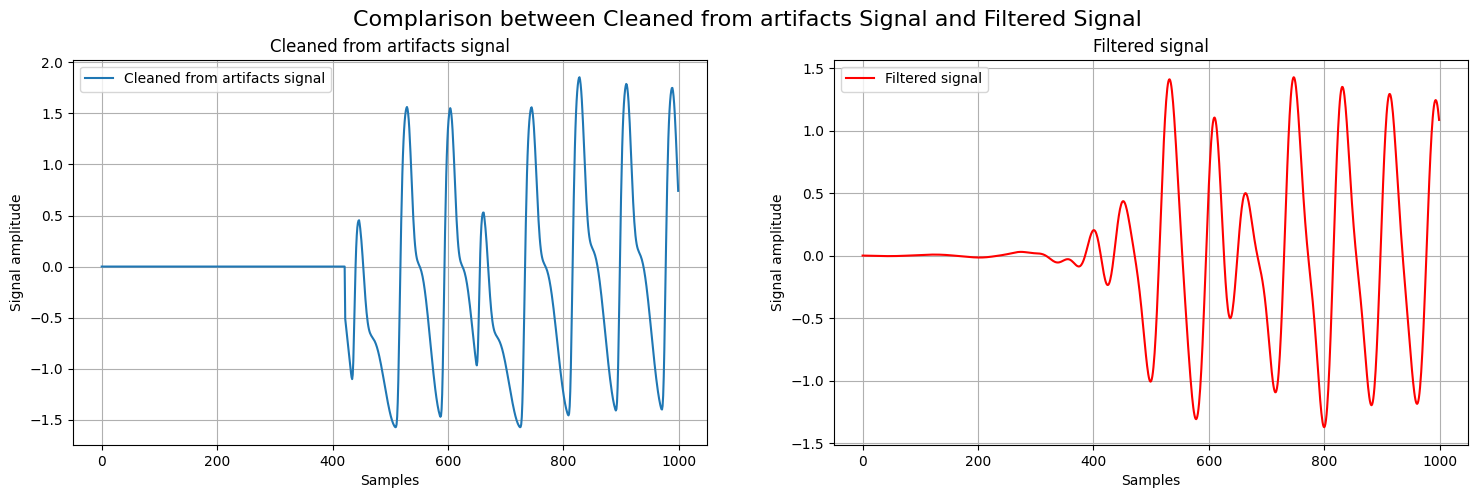

In [ ]:
import matplotlib.pyplot as plt

# Processed signal è il segnale filtrato
processed_signal = processed_signals[9][3000:4000]
ppg_signal = ppg_cleaned_final1[9][3000:4000]

plt.figure(figsize=(18, 5))

# Grafico del segnale originale
plt.subplot(1, 2, 1)
plt.plot(ppg_signal, label='Cleaned from artifacts signal')
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Signal amplitude')
plt.title('Cleaned from artifacts signal')
plt.legend()

# Grafico del segnale filtrato
plt.subplot(1, 2, 2)
plt.plot(processed_signal, label='Filtered signal', color='red')
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Signal amplitude')
plt.title('Filtered signal')
plt.legend()

# Aggiungi un titolo al grafico completo
plt.suptitle('Complarison between Cleaned from artifacts Signal and Filtered Signal', fontsize=16)

plt.show()

# 4 Segmentation and removing of artifacts

To isolate the peaks, we used the function segmenta_picco_ppg.
The initial idea is to create segments that include the peak, starting from the left minimum to the right minimum, to use them for classification. Thus, each segment ultimately comprises a peak, which will then be classified by our models.

To build the segments, the findpeaks function was used on the signal flipped so that it finds not the peaks but the minima surrounding the peaks.

To find the minima, we use the information of the peak positions that we already know. For each peak position, we apply the findpeaks function to the flipped signal to find the left minima by applying it from the origin of the signal up to the peak position, and similarly, to find the right minima, we apply it from the peak position to the end of the signal.

The first step taken in this function is to set the indices of the peaks < 0.1 equal to 0 to eliminate them later. This is because the filter applied in the zero-padding parts, where there were previously artifacts, caused very small amplitude ripples that are not useful for classification, as they represent artifacts.

Once the findpeaks function is applied and all the left and right minima of each peak are found, we take from each peak the last left minimum found and the first right minimum found, as those immediately follow the peak

In [ ]:
import numpy as np
from scipy.signal import find_peaks
def segmenta_picco_ppg(ppg_signal, index_picco):
  sinistra= []
  destra= []
  minimo_destra=0
  minimo_sinistra=0

  # We find the minima to the left and right of the peak
  if ppg_signal[index_picco]<0.1:
    index_picco = 0 #I set the indices of all peaks less than 0.1 to 0.
  else:
    sinistra, _ = find_peaks(-ppg_signal[:index_picco]) #we apply the findpeaks function from the origin of the signal up to the peak to find the left minima

    destra, _ = find_peaks(-ppg_signal[index_picco:])#we apply the findpeaks function from the index peak to the end of the signal to find the right minima
    destra += index_picco
    #We add the index of the maximum to obtain the correct index.
    #This is necessary to shift the indices found on the right side so that they are relative to the actual position in the complete signal and not relative to the position of the peaks


    if sinistra.size > 0 and destra.size > 0:
        minimo_sinistra = sinistra[-1] #I take the last element of the left minima of the peak because it is the closest minimum to the current peak.
        minimo_destra = destra[0] #I take the first element of the right minima of the peak because it is the closest right minimum to the current peak
        #Procedure for the extremes
    elif sinistra.size == 0 and destra.size > 0: #If we are at the beginning of the signal and the minimum is not found.
        minimo_sinistra = 1 #I set the left minimum to 1 instead of 0 so that it is not eliminated later on.
        minimo_destra = destra[0] #not change
    elif destra.size == 0 and sinistra.size > 0: #If we are at the end of the signal and the maximum is not found.
        minimo_destra = len(ppg_signal-1)
        minimo_sinistra = sinistra[-1] #not change

  return minimo_sinistra, minimo_destra, index_picco
 #index picco will be modified to contain 0 for the indices of signals <0.1.

we apply the function for each segment.

In [ ]:
#we save the positions of the minima and maxima in a list.
minimi_sinistra_totale = []
minimi_destra_totale = []

for i in range(len(peak)): # we select the peaks of each signal.
    minimi_sinistra_segnale = []
    minimi_destra_segnale = []

    for j in range(0, len(peak[i])): #I evaluate peak by peak for the single signal.
        min_sinistra, min_destra , peak[i][j][0] = segmenta_picco_ppg(processed_signals[i], peak[i][j][0])
        minimi_sinistra_segnale.append(min_sinistra)
        minimi_destra_segnale.append(min_destra)

    minimi_sinistra_totale.append(minimi_sinistra_segnale)
    minimi_destra_totale.append(minimi_destra_segnale)

# Delete all the zeros


we remove all peaks equal to 0, as in the function segmenta_picco_ppg, we set peaks < 0.1 equal to 0.

In [ ]:
for i in range(len(peak)):
  indici_da_eliminare=[]
  for j in range(len(peak[i])):
    if peak[i][j]==0:
      indici_da_eliminare.append(j)
      indici_da_eliminare_array = np.array(indici_da_eliminare)
  peak[i] = np.delete(peak[i],indici_da_eliminare_array, axis=0)
  label[i] = np.delete(label[i],indici_da_eliminare_array, axis=0) #we also remove the labels related to the deleted peaks.

I do this because when I have signals with amplitude < 0.1, I do not calculate the minimum and maximum, so they are equal to 0 accordingly.
Since I remove the corresponding peaks, I also eliminate the associated minima because they are consequently equal to 0.
The same procedure is applied to the left and right minima.

In [ ]:
for i in range(len( minimi_sinistra_totale)):
  indici_da_eliminare=[]
  for j in range(len( minimi_sinistra_totale[i])):
    if  minimi_sinistra_totale[i][j]==0:
      indici_da_eliminare.append(j)
      indici_da_eliminare_array = np.array(indici_da_eliminare)
  minimi_sinistra_totale[i] = np.delete( minimi_sinistra_totale[i],indici_da_eliminare_array, axis=0)

In [ ]:
for i in range(len( minimi_destra_totale)):
  indici_da_eliminare=[]
  for j in range(len( minimi_destra_totale[i])):
    if  minimi_destra_totale[i][j]==0:
      indici_da_eliminare.append(j)
      indici_da_eliminare_array = np.array(indici_da_eliminare)
  minimi_destra_totale[i] = np.delete( minimi_destra_totale[i],indici_da_eliminare_array, axis=0)

# Segmentation

In [ ]:
def segmenta_picco_ppg(ppg_signal, min_sin, min_destr):
    """
    Segments the PPG signal around the peak.

    Parameters:
    - ppg_signal: The PPG signal
    - index_picco: the index of the peak
    - intervallo_temporale: The desired interval length around the peak (in samples).

    Return:
    - segmento: The segment of the PPG signal around the peak.
    """

    segmento = ppg_signal[min_sin:min_destr] #we take the segment from the left minimum to the right minimum.

    return segmento

 Application of  the segmentation function.

In [ ]:
segmenti_totali = []
for i in range(len(processed_signals)):
  segmenti = []
  for j in range(len(peak[i])):
    segmenti.append(segmenta_picco_ppg(processed_signals[i],minimi_sinistra_totale[i][j],minimi_destra_totale[i][j]))
  segmenti_totali.append(segmenti)

Plot of the single segment.

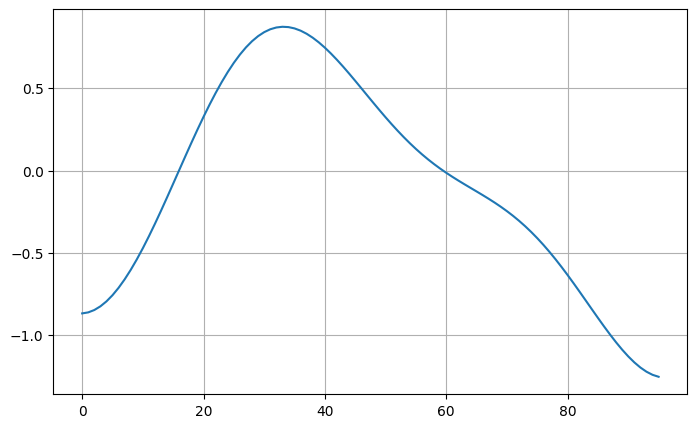

In [ ]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.plot(segmenti_totali[0][8])
plt.grid()

In [ ]:
label[0][0]

# Check normal and abnormal peaks.

Label encoding:

N=0

V=1

S=1

In [ ]:
label_modified = [
    np.where(arr == 'N', 0, arr) for arr in label
]

In [ ]:
label_modified1 = [
    np.where(arr == 'V', 1, arr) for arr in label_modified
]

In [ ]:
label_modified_final = [
    np.where(arr == 'S', 1, arr) for arr in label_modified1
]

In [ ]:
label_train=[]
for i in range (len(segmenti_totali)):
  label_train.extend(label_modified_final[i])

In [ ]:
df = {
    'Label': label_train
}

df = pd.DataFrame(df)

In [ ]:
df

,Label
0,0
1,0
2,0
3,0
4,1
...,...
131730,0
131731,0
131732,0
131733,0


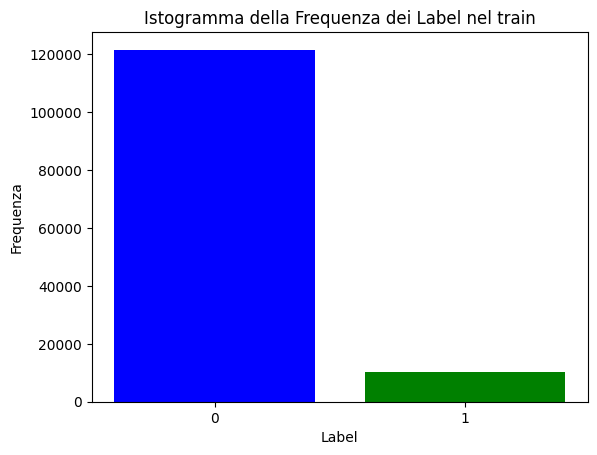

In [ ]:
labels_column = df["Label"]

# Count the occurrences of each label.
conteggio_labels = labels_column.value_counts()

# Extract the labels and values from the count
etichette = conteggio_labels.index
valori = conteggio_labels.values

# Creating the histogram.
plt.bar(etichette, valori, color=['blue', 'green', 'red'])

plt.title('Istogramma della Frequenza dei Label nel train')
plt.xlabel('Label')
plt.ylabel('Frequenza')

plt.show()

#5. Save and Load Data

In [ ]:
save_directory = '/gdrive/MyDrive/corino/Processing_definitivo'
# Change the current working directory
os.chdir(save_directory)

with open('segmenti_totali_check_28_01.txt', 'wb') as data_file:
  pickle.dump(segmenti_totali, data_file)
with open('label_check_28_01.txt', 'wb') as data_file:
  pickle.dump(label, data_file)

In [ ]:
save_directory = '/gdrive/MyDrive/corino/Processing_definitivo'
# Change the current working directory
os.chdir(save_directory)

# Load the data from the files
with open('segmenti_totali_check_28_01.txt', 'rb') as data_file:
    segmenti_totali = pickle.load(data_file)
with open('label_check_28_01.txt', 'rb') as data_file:
    label = pickle.load(data_file)